In [1]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools

In [2]:
import pickle # Importamos la librería necesaria ya que los datos están en formato pickle

data_path = '../../../Data/'
# Carga de datos de entrenamiento
with open(data_path + 'IDC_train.dat', 'rb') as f:
    (X_train, y_train) = pickle.load(f)

# Carga de datos de test
with open(data_path + 'IDC_test.dat', 'rb') as f:
    (X_test, y_test) = pickle.load(f)

# Comprobamos la cantidad de datos que tenemos
print(X_train.shape)
print(y_train.shape)  

(222019, 50, 50, 3)
(222019,)


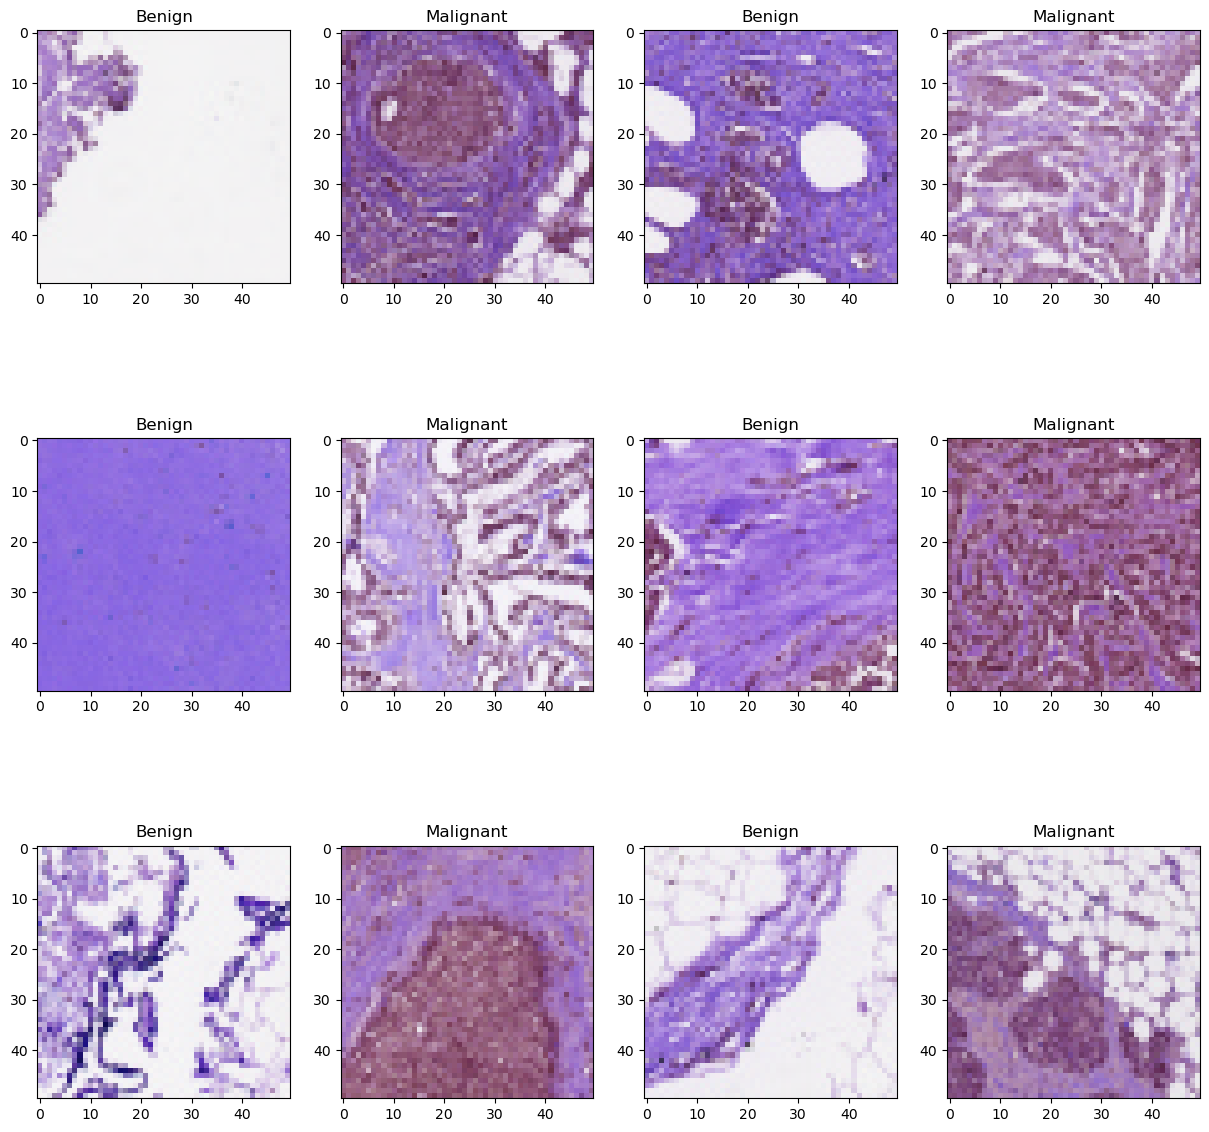

In [3]:
import matplotlib.pyplot as plt

w = 60
h = 40
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 3

# Filtrar las imágenes y etiquetas según su categoría
benign_images = X_train[y_train == 0]
malignant_images = X_train[y_train == 1]

# Calcular el número máximo de imágenes a mostrar
max_images = min(len(benign_images), len(malignant_images))

for i in range(1, columns * rows + 1):
    ax = fig.add_subplot(rows, columns, i)
    if i % 2 == 1:
        # Mostrar una imagen benigna
        index = (i - 1) // 2
        ax.title.set_text('Benign')
        plt.imshow(benign_images[index], interpolation='nearest')
    else:
        # Mostrar una imagen maligna
        index = (i - 1) // 2
        ax.title.set_text('Malignant')
        plt.imshow(malignant_images[index], interpolation='nearest')

    if i >= 2 * max_images:
        # Si ya hemos mostrado el número máximo de imágenes, salir del bucle
        break

plt.show()

In [4]:
BATCH_SIZE = 16

train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [5]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )
    
    return model

In [6]:
K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(50, 50, 3)
)

model = build_model(resnet, lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1, 1, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 3842      
                                                                 
Total params: 18,333,506
Trainable params: 18,100,610
No

In [7]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [8]:
# Convert labels to Keras Categorical to use in model
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

In [9]:
epochs = 10
history = model.fit(
    train_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=X_train.shape[0] / BATCH_SIZE,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[learn_control, checkpoint]
)

# Guardar el modelo después del entrenamiento
model.save("trained_resnet_epochs_{}.h5".format(epochs))

Epoch 1/10
  493/13876 [>.............................] - ETA: 1:23:43 - loss: 0.5179 - accuracy: 0.7760

KeyboardInterrupt: 

In [ ]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['acc', 'val_acc']].plot()

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()